In [0]:
# !unzip kichua.zip
# !unzip -o kichua_validation.zip;
# !unzip -o kichua_domain.zip;
# !pip install medpy

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
import numpy as np
import nibabel as nib
import random
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
from tqdm  import tqdm
from medpy.metric.binary import dc
from scipy import signal

In [34]:
######### PARAMETERS 

gt_base_path = 'domain_gt'
img_base_path = 'domain_img'

######### PARAMETERS 
train = False

raw_img_filenames = os.listdir(img_base_path)
raw_img_filenames

['CC0060_philips_3_29_M.nii.gz',
 'CC0061_philips_3_55_F.nii.gz',
 'CC0062_philips_3_52_F.nii.gz']

In [0]:
max_idx = 1699
min_idx = 12
index_reg_exp = 'CC(.*?)_'

def filter_function(file_name):
  index = re.findall(index_reg_exp, file_name)[0]  
  index = int(index)
  if min_idx <= index <= max_idx:
    return True
  return False

img_filenames = []
for file_name in raw_img_filenames:
  if filter_function(file_name):
    img_filenames.append(file_name)

In [0]:
gt_filenames = []
for img_filename in img_filenames:
    comma_idx = img_filename.find('.')
    gt_file_name = img_filename[:comma_idx] + '_ss' + img_filename[comma_idx:]    
    gt_filenames.append(gt_file_name)

In [37]:
print('Files count', len(img_filenames))

Files count 3


In [0]:
def loader(path):
    data = nib.load(path)
    img = data.get_fdata()
    return img

imgs = []
gts = []
for img_filename, gt_filename  in zip(img_filenames, gt_filenames):
    gt_path = os.path.join(gt_base_path, gt_filename)
    img_path = os.path.join(img_base_path, img_filename)    

    gt = loader(gt_path)
    img = loader(img_path)
    
    imgs.append(img)
    gts.append(gt)

In [0]:
def crop(img, gt, voxes_size, mini_voxel_size, start_coordinates):
    img_size = np.array(img.shape)
    gt_size = np.array(gt.shape)
    start_coordinates = np.array(start_coordinates)
    
    end_coordinates = start_coordinates + voxes_size
    if not np.all(end_coordinates < img_size):
        raise AttributeError('Crop is outsize of image')
       
    cropped_img = img[
        start_coordinates[0]:end_coordinates[0],
        start_coordinates[1]:end_coordinates[1],
        start_coordinates[2]:end_coordinates[2]
    ]
    
    assert np.all(np.array(cropped_img.shape) == voxes_size)
    
    
    cropped_gt_start = (end_coordinates + start_coordinates) // 2 # - mini_voxel_size // 2
    
    cropped_gt_end = cropped_gt_start + mini_voxel_size 
    
    cropped_gt = gt[
        cropped_gt_start[0]:cropped_gt_end[0],
        cropped_gt_start[1]:cropped_gt_end[1],
        cropped_gt_start[2]:cropped_gt_end[2]
    ]
    
    assert np.all(np.array(cropped_gt.shape) == mini_voxel_size)
    
    return cropped_img, cropped_gt

In [0]:
def augmentation(imgs, gts):
  augmentation_imgs = []
  augmentation_gts = []

  for idx in range(len(imgs)):
    augmentation_imgs.append(
        imgs[idx][:,:,::-1].copy()
    )
    
    augmentation_gts.append(
        gts[idx][:,:,::-1].copy()
    )
    
  return imgs + augmentation_imgs, gts + augmentation_gts


class MriDataset(data.Dataset):
    def __init__(self, X, y, crop_size, mini_crop_size, crops_per_image, crop_function):
        super(MriDataset)
        self.X = [x / x.max() for x in X]        
        self.y = y
        self.crop_size = crop_size
        self.mini_crop_size = mini_crop_size
        self.crops_per_image = crops_per_image
        self.crops_per_image = crops_per_image
        self.crop_function = crop_function
        self.crops, self.img_idxs = self.create_crops()

        permutation = np.random.permutation(len(self.crops))
        self.crops = np.array(self.crops)[permutation]
        self.img_idxs = np.array(self.img_idxs)[permutation]              
        
    def create_crops(self):
        crops = []
        img_idxs = []
        
        for i in range(len(self.X)):
            x_shape = np.array(self.X[i].shape)
            y_shape = np.array(self.y[i].shape)
            
            sub_crops = []
            for j in range(self.crops_per_image):
                x_max = x_shape[0] - self.crop_size
                y_max = x_shape[1] - self.crop_size
                z_max = x_shape[2] - self.crop_size
                
                x = np.random.randint(0, x_max)
                y = np.random.randint(0, y_max)
                z = np.random.randint(0, z_max)
                
                crops.append([x, y, z])                
                img_idxs.append(i)
            
        return crops, img_idxs
        
    def __len__(self):
        return len(self.X) * self.crops_per_image
    
    def __getitem__(self, idx):
        crop = self.crops[idx]
        img = self.X[self.img_idxs[idx]]
        gt = self.y[self.img_idxs[idx]]
        x, y = self.crop_function(img, gt, self.crop_size, self.mini_crop_size, crop)

        return torch.Tensor(x[None,:,:,:]), torch.Tensor(y[None,:,:,:])

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer1 = self._make_conv_layer(out_channels=16, k_size=4)
        self.conv_layer2 = self._make_conv_layer(in_channels=16, out_channels=24)
        self.conv_layer3 = self._make_conv_layer(in_channels=24, out_channels=28)
        self.conv_layer4 = self._make_conv_layer(in_channels=28, out_channels=34)
        self.conv_layer5 = self._make_conv_layer(in_channels=34, out_channels=42)
        self.conv_layer6 = self._make_conv_layer(in_channels=42, out_channels=50)
        self.conv_layer7 = self._make_conv_layer(in_channels=50, out_channels=50)
        self.final_layer = self._make_conv_layer(in_channels=50, out_channels=1, activation=False)

    def forward(self, x):

        x = self.conv_layer1(x)
        # Max pooling over a (2, 2, 2) window
        x = F.max_pool3d(x, (2, 2, 2))
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = self.final_layer(x)
        x = torch.sigmoid(x)

        return x

    @staticmethod
    def _make_conv_layer(out_channels, in_channels=1, k_size=5, activation=True):
        if activation:
            conv_layer = nn.Sequential(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(k_size, k_size, k_size),
                          padding=0),
                nn.LeakyReLU(),  # (!)Think of padding(!)
            )
        else:
            conv_layer = nn.Conv3d(in_channels=in_channels, out_channels=out_channels,
                                   kernel_size=(k_size, k_size, k_size), padding=2)

        return conv_layer

In [42]:
batch_size = 4
epochs = 100000000
crops_per_image = 500
lr = 1e-5
epochs_per_save = 1

crop_size = 65
mini_crop_size = 7

device = torch.device('cpu')
if torch.cuda.is_available():
    print('GPU !!!')
    device = torch.device('cuda:0')

GPU !!!


In [0]:
if not os.path.exists('models'):
  os.mkdir('models')

In [44]:
net = Net().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)  # lr = 1e-5 in the original paper

augmentation_imgs, augmentation_gts = augmentation(imgs, gts)
mri_dataset = MriDataset(augmentation_imgs, augmentation_gts, crop_size, mini_crop_size, crops_per_image, crop_function=crop)
mri_dataset[len(mri_dataset) - 1]
mri_dataloader = data.DataLoader(mri_dataset, batch_size)
assert len(mri_dataset) == len(augmentation_imgs) * crops_per_image
print(len(mri_dataset))

3000


In [45]:
if train:
  total_losses = []

  for epoch in range(epochs):
      losses = []
      for x, y in tqdm(mri_dataloader):
          x, y = x.to(device), y.to(device)        
          
          optimizer.zero_grad()        
          outputs = net(x)
          loss = criterion(outputs, y)
          losses.append(loss.detach().cpu().item())
          
          loss.backward()
          optimizer.step()
          del x
          del y
      if epoch % epochs_per_save == 0:
        print(epoch)
        torch.save(net.state_dict(), os.path.join('models', f'model_epoch_{epoch:03}'))
      
      mean_loss = np.mean(losses)
      total_losses.append(mean_loss)
      
      pd.DataFrame(total_losses).to_csv('loss.csv', index='Epoch')
      print('iter', epoch, ':', mean_loss)
else:
    net.load_state_dict(torch.load("model_epoch_180"))
    net.to(device)
    print('Loaded!')

Loaded!


In [112]:
n = 0
pad = ((0,0), (15,0), (0,15))
img = augmentation_imgs[n]
img = np.pad(img, pad)

gt = augmentation_gts[n]
gt = np.pad(gt, pad)
img = img / img.max()
diff = crop_size // 2
# layer = 45
# pred_layer = layer - 32
max_x, max_y, max_z = img.shape
preds = np.zeros_like(img)
coef = np.zeros_like(img)
# kernel = gkern(mini_crop_size, 5)
# batch = []
for z in tqdm(range(0, max_z - crop_size, 7)):
    for y in range(0, max_y - crop_size, 7):
      for x in range(0, max_x - crop_size, 7):
        pred_y = y + diff 
        pred_z = z + diff
        pred_x = x + diff
        vis_x, vis_y = crop(img, gt, crop_size, mini_crop_size, (x, y, z))          
        output = net(torch.Tensor(vis_x[None,None,:,:,:]).to(device))[0,0].data.cpu().numpy()              
        preds[pred_x:pred_x + mini_crop_size,pred_y:pred_y + mini_crop_size, pred_z: pred_z + mini_crop_size] += output
        
        coef[pred_x:pred_x + mini_crop_size, pred_y:pred_y + mini_crop_size, pred_z: pred_z + mini_crop_size] += 1

coef[coef == 0] = 1
preds = np.array(preds)



  0%|          | 0/28 [00:00<?, ?it/s]

  4%|▎         | 1/28 [00:11<05:23, 11.97s/it]

  7%|▋         | 2/28 [00:23<05:09, 11.92s/it]

 11%|█         | 3/28 [00:35<04:57, 11.89s/it]

 14%|█▍        | 4/28 [00:47<04:44, 11.87s/it]

 18%|█▊        | 5/28 [00:59<04:32, 11.86s/it]

 21%|██▏       | 6/28 [01:11<04:20, 11.85s/it]

 25%|██▌       | 7/28 [01:22<04:08, 11.85s/it]

 29%|██▊       | 8/28 [01:34<03:56, 11.85s/it]

 32%|███▏      | 9/28 [01:46<03:45, 11.85s/it]

 36%|███▌      | 10/28 [01:58<03:33, 11.85s/it]

 39%|███▉      | 11/28 [02:10<03:21, 11.85s/it]

 43%|████▎     | 12/28 [02:22<03:09, 11.85s/it]

 46%|████▋     | 13/28 [02:34<02:57, 11.85s/it]

 50%|█████     | 14/28 [02:45<02:45, 11.85s/it]

 54%|█████▎    | 15/28 [02:57<02:34, 11.85s/it]

 57%|█████▋    | 16/28 [03:09<02:22, 11.85s/it]

 61%|██████    | 17/28 [03:21<02:10, 11.87s/it]

 64%|██████▍   | 18/28 [03:33<01:59, 11.95s/it]

 68%|██████▊   | 19/28 [03:45<01:48, 12.02s/it]

 71%|███████▏  | 20/28 [03:57<01:35,

In [118]:
# img.shape
# augmentation_imgs[0].shape

(180, 240, 240)

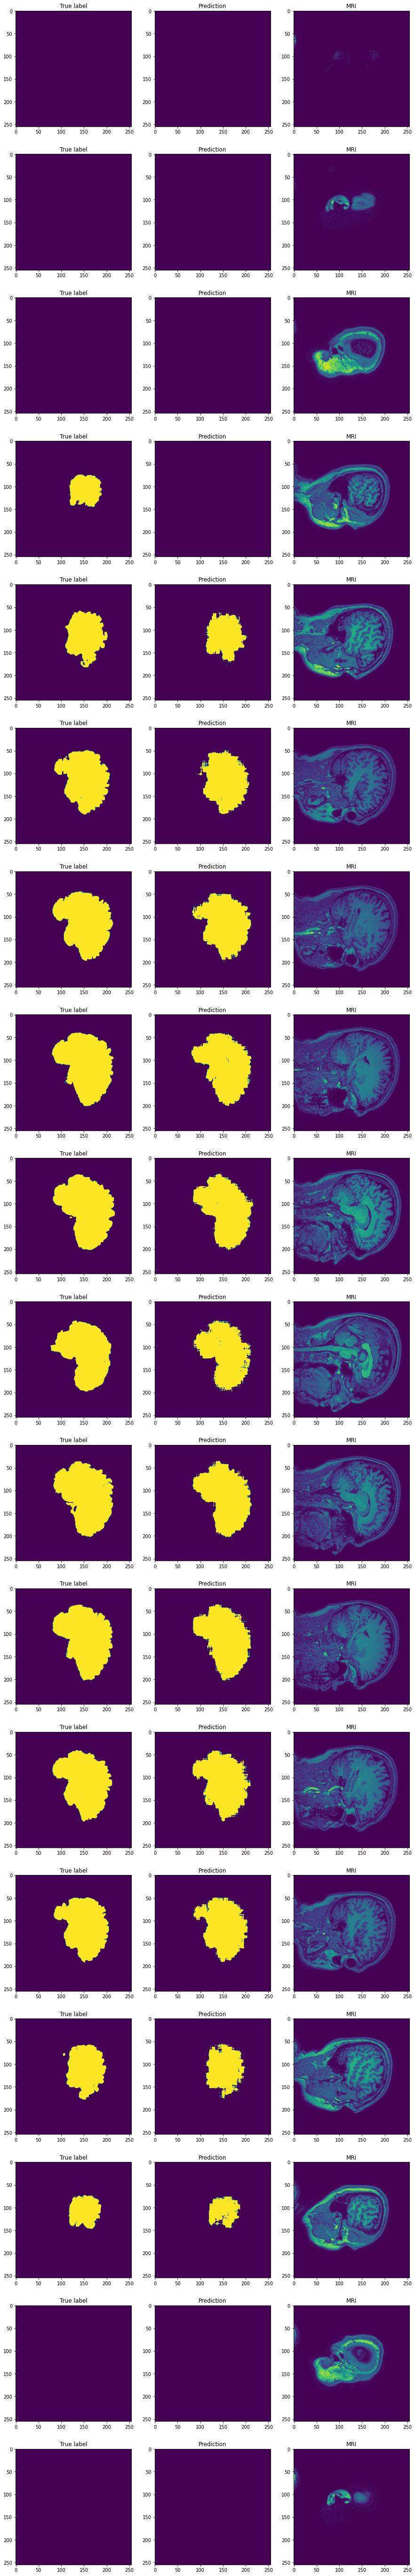

In [115]:
lays = range(0, len(preds), 10)
fig, axes = plt.subplots(len(lays), 3, figsize=(15,100))

tmp_img = (preds > 0.5)
# tmp_gt = gt[:,]
for idx, lay in enumerate(lays):  

  axes[idx, 1].imshow(tmp_img[lay])
  axes[idx, 1].set_title('Prediction')

  axes[idx, 0].imshow(gt[lay])
  axes[idx, 0].set_title('True label')

  axes[idx, 2].imshow(img[lay])
  axes[idx, 2].set_title('MRI')

In [0]:
fig.savefig('domain_mri_test_0')

In [119]:
# fig, (pred_axis, gt_axis) = plt.subplots(1, 2, figsize=(15,7))
# pred_img = (preds / coef) > 0.5
# pred_img = (preds / coef) > 0.5
# tmp_img = scipy.ndimage.gaussian_filter(pred_img, 0.1) 
# tmp_img = scipy.ndimage.gaussian_filter(pred_img, ) 
# tmp_img = scipy.ndimage.gaussian_filter(preds  / coef, 1) > 0.5
# lay = 10

# tmp_img = (preds / coef) > 0.5
# tmp_img = scipy.ndimage.gaussian_filter(tmp_img, 1) > 0.5
# pred_axis.imshow(tmp_img[lay])
# pred_axis.set_title('Prediction')

# gt_axis.imshow(gt[lay])
# gt_axis.set_title('Target');
# (preds != gt[layer]).sum()
# print('Current layer dice', dc(tmp_img, gt))
print('3D dice', dc(tmp_img, gt))

3D dice 0.9297703131714502
